In [1]:
# train a generative adversarial network on a one-dimensional function
import numpy as np
from numpy.random import rand
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import scipy.stats

Using TensorFlow backend.


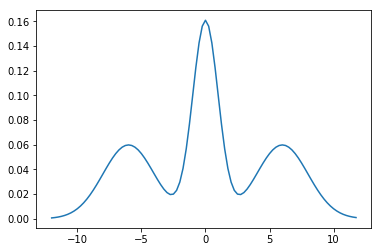

In [2]:
# define function
def f_x(x):
    N1 = scipy.stats.norm(0, 1)
    N2 = scipy.stats.norm(-6, 2)
    N3 = scipy.stats.norm(6, 2)
    
    return 0.4*N1.pdf(x)+0.3*N2.pdf(x)+0.3*N3.pdf(x)

# display the function
x = np.arange(-12,12,0.25)
y = np.array([f_x(i) for i in x])
plt.plot(x,y)
plt.show()

In [3]:
# define the standalone discriminator model
def define_discriminator(n_inputs=2):
    model = Sequential()
    model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# create the discriminator
discriminator = define_discriminator()

In [4]:
# define the standalone generator model
def define_generator(latent_dim, n_outputs=2):
    model = Sequential()
    model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
    model.add(Dense(n_outputs, activation='linear'))
    return model

# size of the latent space
latent_dim = 10

# create the generator
generator = define_generator(latent_dim)

In [5]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

# create the gan
gan_model = define_gan(generator, discriminator)

In [6]:
# generate n real samples with class labels
def generate_real_samples(n):
    X1 = np.random.uniform(low=-12, high=12, size=n)
    X2 = np.array([f_x(i) for i in X1])
    X1 = X1.reshape(n,1)
    X2 = X2.reshape(n,1)
    y = np.ones((n,1))
    return np.hstack((X1, X2)), y

In [7]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
    # generate points in the latent space
    x_input = randn(latent_dim * n)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n, latent_dim)
    return x_input

In [8]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels
    y = np.zeros((n, 1))
    return X, y

In [9]:
# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):

    # prepare real samples
    x_real, y_real = generate_real_samples(n)
    # evaluate discriminator on real examples
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
    # evaluate discriminator on fake examples
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print(epoch, acc_real, acc_fake)
    
    # scatter plot real and fake data points
    plt.scatter(x_real[:, 0], x_real[:, 1], color='red')
    plt.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
    plt.show()

/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


999 0.0 1.0


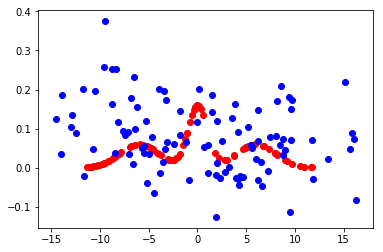

1999 0.49000000953674316 0.5400000214576721


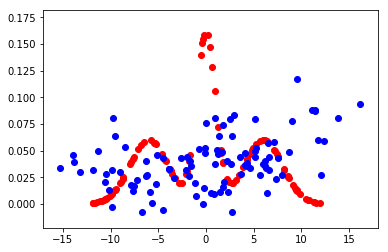

2999 0.6100000143051147 0.4399999976158142


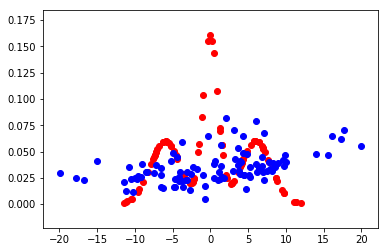

3999 0.6200000047683716 0.47999998927116394


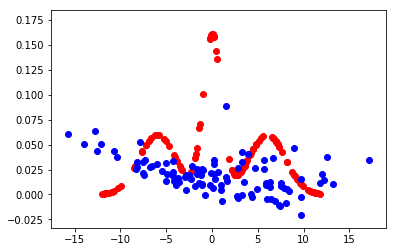

4999 0.550000011920929 0.49000000953674316


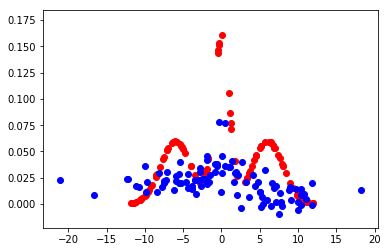

5999 0.27000001072883606 0.7099999785423279


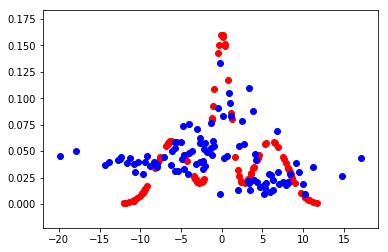

6999 0.4300000071525574 0.6000000238418579


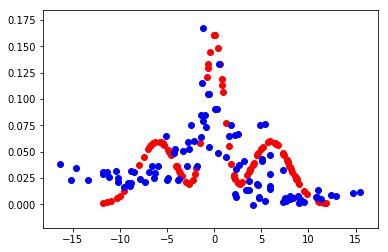

7999 0.3700000047683716 0.4699999988079071


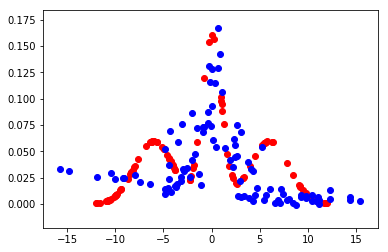

8999 0.3400000035762787 0.6000000238418579


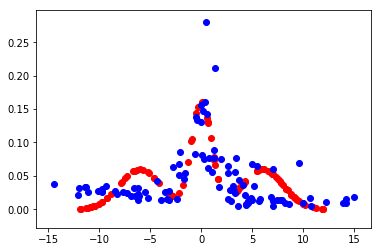

9999 0.3700000047683716 0.5600000023841858


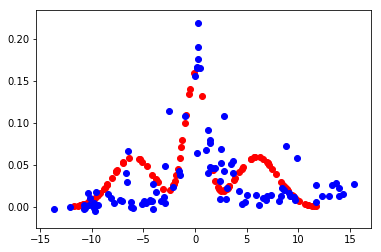

In [10]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=258, n_eval=1000):
    # determine half the size of one batch, for updating the discriminator
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
    # train discriminator model
        # prepare real samples
        x_real, y_real = generate_real_samples(half_batch)
        # prepare fake examples
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator
        d_model.train_on_batch(x_real, y_real)
        d_model.train_on_batch(x_fake, y_fake)
        
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = np.ones((n_batch, 1))
        # update the generator via the discriminator's error
        gan_model.train_on_batch(x_gan, y_gan)
        
        
        # evaluate the model every n_eval epochs
        if i % n_eval == 0:
            summarize_performance(i, g_model, d_model, latent_dim)

# train model
train(generator, discriminator, gan_model, latent_dim)

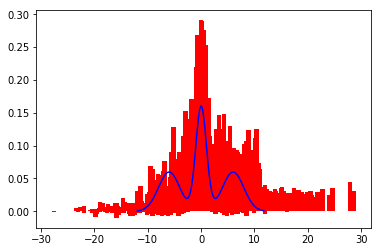

In [24]:
#generating 3000 points from the GAN

x_test, y_test = generate_fake_samples(generator, latent_dim, 3000)
#print(x_test, y_test)
plt.bar(x_test[:,0],x_test[:,1],color = "red")
plt.plot(x,y,color = "blue")
plt.show()

In [39]:
from sklearn import mixture

g = mixture.GaussianMixture(n_components=3)

ys = x_test[:,1].reshape(3000,1)

g.fit(ys)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [45]:
print(g.weights_, g.means_, g.covariances_)

[0.61409634 0.10824275 0.27766091] [[0.00867606]
 [0.13305114]
 [0.04597455]] [[[5.41278634e-05]]

 [[2.74404235e-03]]

 [[5.85964693e-04]]]


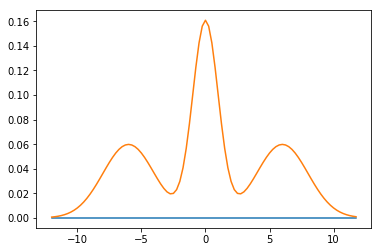

In [49]:
# define function
def f_x2(x):
    N1 = scipy.stats.norm(0.008, 5.41278634e-05)
    N2 = scipy.stats.norm(0.133, 2.74404235e-03)
    N3 = scipy.stats.norm(0.045, 5.85964693e-04)
    
    return 0.614*N1.pdf(x)+0.108*N2.pdf(x)+0.27*N3.pdf(x)

# display the function
x2 = np.arange(-12,12,0.25)
y2 = np.array([f_x2(i) for i in x])
plt.plot(x2,y2)
plt.plot(x,y)
plt.show()